# CISC 873 Data Mining Competition #4
name: Asmaa Qindeel


Competition #4: https://www.kaggle.com/c/cisc-873-dm-f22-a4
# Multi-Modality and Mult-Task Learning

### TOPICS:
* [Refrences](#ref)
* [Questions & Answers](#Questions)
* [Problem and Protocol](#intro)

**Experiment Part**
* [Preparing workspace: gathering info about the data](#pre)

> * [About the Trials](#notes)


* [Trail 1: Text Input with GRU](#t1)
* [Trail 2: Text Input with BiDirectional layer](#t2)
* [Trail 3: Image Input with Conv2d](#t3)
* [Trail 4: Image Input with Dropout](#t4)
    * [Trial 4.1: AlexNet Architecture](#t4.1)
* [Trail 5: Multi-modality learning](#t5)
* [Trial 6: Multi-objective learning.(predicting both price and type](#6)

[**Conclusion**](#conc)

<a class="anchor" id="ref"></a>
# References:


---


[1]Early stopping: https://machinelearningmastery.com/how-to-stop-training-deep-neural-networks-at-the-right-time-using-early-stopping/

[2] Regularization: https://machinelearningmastery.com/how-to-reduce-overfitting-in-deep-learning-with-weight-regularization/

[3] LangID: https://www.kaggle.com/code/rtatman/analyzing-multilingual-data/notebook

https://machinelearningmastery.com/multi-class-classification-tutorial-keras-deep-learning-library/

lab_873_mml_mtl

---

<a class="anchor" id="Questions"></a>

# Questions:  

1. Is fully-connected model a good one for sequential data? Why? How about for image data? Is it good? Why?
- No it is not, because it's design can't extract information from sequential data, it is designed to handle only non sequential. It is also not good for image data because it can't quite extract image features, it only learns the patterns, but image processing depend on image features not pixel pattern.
2. What is gradient vanishing and gradient explosion, and how GRU/LSTM tries to mitigate this problem?
- gradient vanishing is when the gradient value decreases until it dies, so the weights can't be updated with that. Explosion is when it gets very high values that it breaks the network, causing high cost calculations, or just network not converging. Gradient problems can be solved by GRU/LSTM nets, which are designed to choose whether to keep a certain iteration's gradient calculations or forget them, Meaning choose which value contributes to the gradient. Which by dafalut fixis the vanishig||exploding problem.
3. What is multi-objective/multi-task learning? What is multi-modality learning? How do you use them in this assignment?
- multi-objective/multi-task learning is setting your eye(or the model's eye) on multi goals at the same time. Multi-modality is learning from various sources of input, like images and text at the same time. So the first is about the output, the second is about the input, this is another technique to mimic the human learning that dependes on our many senses at the same time, and the ability to solve several problems simultaneously. And we use both in this assignment, having the input be both text and images, and the output be two targets.
4. What is the difference among xgboost, lightgbm and catboost
- I haven't tried any, but, According to this article (https://www.springboard.com/blog/data-science/xgboost-random-forest-catboost-lightgbm/#:~:text=As%20of%20CatBoost%20version%200.6,reported%20much%20faster%20than%20XGBoost.) CatBoost is faster.

# Problem Formulation:
<a class="anchor" id="intro"></a>

https://www.kaggle.com/c/cisc-873-dm-f22-a4

This is a multi--task, multi-modality problem, our input is text descriping a rental place, and images of that place, our target is both the (price and type) of that rental place.
This problem is for Airbnb, a vacation rental company to help the new hosts with price suggestions for their rental place.

In this project i'll explore the architecture of multi-modality system.

The ideal solution i think compining the two inputs together(text and images) will increase the probability and cause the model to be more sure of its predictions.
Challenges will include architecture design, parameter tuning(one doesn't simply **PICK** hyperparameters).

Metric used in this problem is `accuracy`.


## The Impact:

Solving this problem will help the new users in Airbnb with estimating the right price for their rental. for me, i shall learn; How to use multi-modality to train a system. How build the architecture for that. How to handle the multi-task output.  


# Experimental Protocol:
---
First i'll try to solve the problem with single modes separately, meaning trainig model with text and training another model with images, then comapre the results with a third multi-mode model that will be trained with both text and images. 
The architectures i'll be using is simple, no more than 4~5 layers in a model, because the resources i have isn't impressive. 


<a class="anchor" id="pre"></a>
## Experiment Preparations
Loading the data and importing the liberaries

In [46]:
# ! wget https://github.com/CISC-873/Information-2021/releases/download/data/a4.zip

# ! unzip -q a4.zip

In [47]:
import pandas as pd
import numpy as np

# my folder of images
initial_path = 'D:/Workspace/Datasets/C4/'
train_file = pd.read_csv(initial_path + 'train_xy.csv')
test_file = pd.read_csv(initial_path + 'test_x.csv')
df = train_file.copy()
df_test = test_file.copy()
df

,summary,image,type,price
0,"Spacious, sunny and cozy modern apartment in t...",img_train/0.jpg,Apartment,1
1,Located in one of the most vibrant and accessi...,img_train/1.jpg,Apartment,0
2,Logement coquet et douillet à 10 minutes du ce...,img_train/2.jpg,Apartment,1
3,"Beautiful and spacious (1076 sc ft, / 100 mc) ...",img_train/3.jpg,Apartment,1
4,Très grand appartement ''rustique'' et très ag...,img_train/4.jpg,Apartment,0
...,...,...,...,...
7622,"Un grand logement 4 et 1/2, tout inclut, bien ...",img_train/7626.jpg,Apartment,0
7623,Magnificent condo directly on the river. You w...,img_train/7627.jpg,Apartment,2
7624,This apartment is perfect for anyone visiting ...,img_train/7628.jpg,Apartment,1
7625,"It is a cozy ,clean ,and comfortable apartment...",img_train/7629.jpg,Apartment,0


In [48]:
#libs for modeling

# NLTK tools
from nltk.stem.snowball import SnowballStemmer
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

#vectorizor
# from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

# building model and tunign tools
from sklearn.model_selection import train_test_split,  PredefinedSplit
from sklearn.metrics import roc_auc_score, classification_report, accuracy_score
# from sklearn.pipeline import Pipeline
# from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

#tools for image preparation
from ast import literal_eval
from tqdm.notebook import tqdm
from PIL import Image
import os

#import models
# from sklearn.linear_model import LogisticRegression
# from xgboost import XGBClassifier

#import tensorflow and keras layersand optimizers
import tensorflow
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import SGD, Adadelta, Adam, Adamax ,Adagrad, RMSprop, Nadam
from tensorflow.keras.layers import Dense, Dropout, Embedding, SpatialDropout1D, BatchNormalization, Bidirectional
from tensorflow.keras.layers import Activation, Dropout, Flatten, Conv2D, MaxPooling2D,MaxPool2D
from tensorflow.keras.regularizers import l1, l2, l1_l2
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import LSTM , GRU , SimpleRNN
from tensorflow.keras.callbacks import ModelCheckpoint

np.random.seed(0)

Let's take a look at the data distribution

In [49]:
#check class distribution
df.type.value_counts()

Apartment                 5765
Condominium                691
House                      406
Loft                       324
Townhouse                  167
Serviced apartment          77
Bed and breakfast           38
Guest suite                 32
Hostel                      26
Bungalow                    25
Guesthouse                  14
Cottage                     12
Aparthotel                  12
Boutique hotel              10
Other                        8
Villa                        7
Tiny house                   3
Cabin                        2
Boat                         2
Camper/RV                    2
Casa particular (Cuba)       1
Earth house                  1
Hotel                        1
Castle                       1
Name: type, dtype: int64

In [ ]:
#check class distribution
df.price.value_counts()

0    4737
1    2403
2     487
Name: price, dtype: int64

>> Class 2 minority may cause a problem

In [50]:
#check null values
null_count = df.isnull().sum().sort_values()
null_count

image        0
type         0
price        0
summary    301
dtype: int64

In [53]:
# first label encode the type
df['type'] = df.type.astype('category').cat.codes

# get the number of types, and classes of prices for later use
types_no = len(df.type.unique())
prices_no = len(df.price.unique())

# print the total number of unique outputs (later used for prediction)
types_no, prices_no

(24, 3)

<a class="anchor" id="notes"></a>
# Trials x.b:
## keeping only the majority language:
I first did the trials(the ones with text input only) with one tokentizer, then i noticed that the text data is not all one language, the first sample is actually french.

So here, I iterated back to check the data. I found that it is mostly english and french.

**Corrective Action:** So in Trial x.b, which is the second version of my trials , i dropped other languages and kept english text only. That decision was based on the fact that english samples were 70~72% in train/test data. Of course this resulted in high bias model. It couldn't handle the test data. which makes sense since i dropped a big portion of the train samples(I finally found some sense. In comparison to last assignment, which nothing made sense in it).

# Trials x.c:
## Splitting tokenizer over languages:
After Trials x.b where i was just lazy and dropped all that is not english, I to take them all in and not take the shortcut :D.

**Corrective Action:** So in Trial x.c, which is the third version of my trials , i rebuilt the tokenizer as two tokenizers. One for english and one for french text. since English is aroung 70% of the data and French is less than 30%, so they are the majority languages. 

I use  `langid` liberary to get the language of each text

This lead to upgrade in val&test accuracy by around 0.002. Which was not worth the effort Really :') .

**when I Break my back preprocessing the data, but the accuracy gets higher by 0.001**
![image](https://i.imgflip.com/42tfy6.png)


In [101]:
#first get 'langid' liberary, used to identify language of the given text
# ! pip install langid
import langid

In [102]:
#this is how the lngid works
df.summary[0:4].apply(langid.classify)

0     (en, -671.7185382843018)
1     (en, -720.2096455097198)
2     (fr, -582.2557005882263)
3    (en, -1058.9362189769745)
Name: summary, dtype: object

In [103]:
#make sure the summary column is str
df['summary'] = df['summary'].astype(str)
# get the language id for each text sample
ids_langid = df.summary[0:-1].apply(langid.classify)

#notice that the langid lib is not very effecint when it comes to non-europian languages
        # as stated here https://www.kaggle.com/code/rtatman/analyzing-multilingual-data/notebook

<AxesSubplot:>

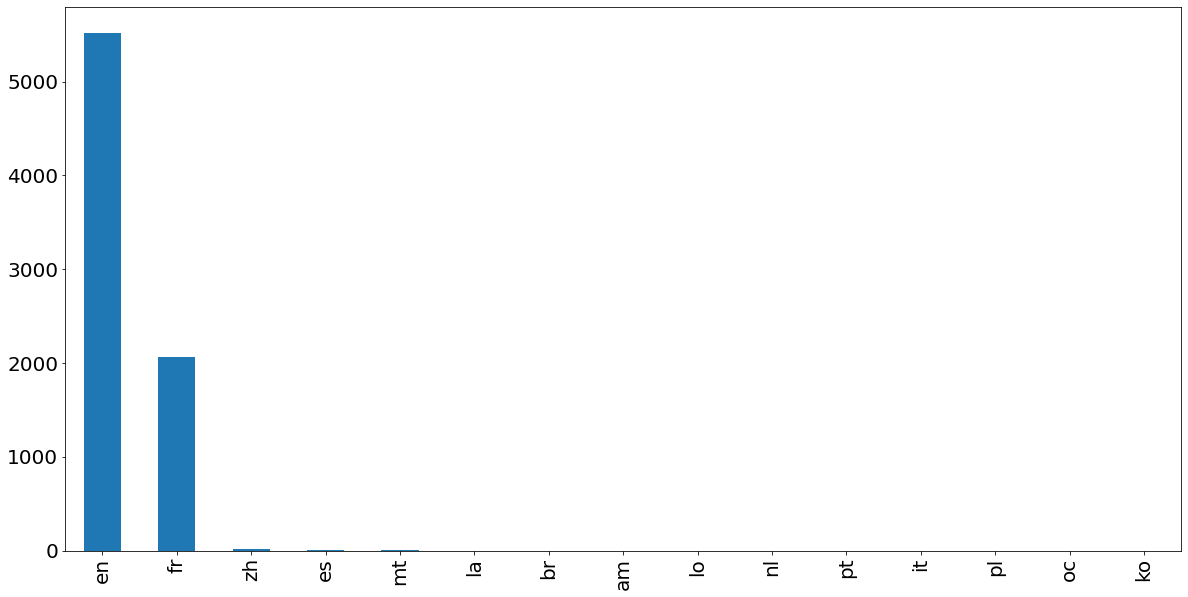

In [104]:
# get just the language label from the tuble outout of the apply method, as DataFrame
langs_df = pd.DataFrame(ids_langid.apply(lambda tuple: tuple[0]))

#get the distribution of langs
langs_count = langs_df.summary.value_counts()

#plot the distribution
langs_count.plot.bar(figsize=(20,10), fontsize=20)

> So, english and french are the most dominent languages in our train set,

Lets check for test data too:

In [105]:
#make sure the summary column is str
df_test['summary'] = df_test['summary'].astype(str)
# get the language id for each text sample
ids_langid_test = df_test.summary[0:-1].apply(langid.classify)

<AxesSubplot:title={'center':'Languages of test data'}, ylabel='number of samples'>

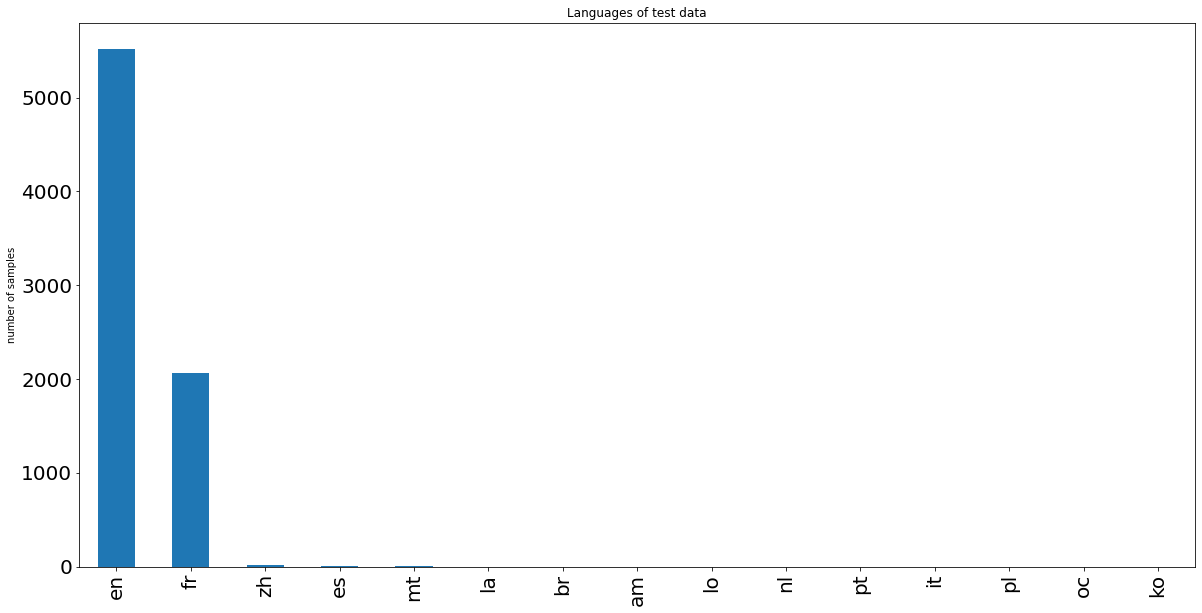

In [106]:
# get just the language label from the tuble outout of the apply method, as DataFrame
langs_df_test = pd.DataFrame(ids_langid_test.apply(lambda tuple: tuple[0]))

#get the distribution of langs
langs_count = langs_df.summary.value_counts()

#plot the distribution
langs_count.plot.bar(figsize=(20,10), fontsize=20,
                     title = 'Languages of test data', ylabel = 'number of samples')

> English and French it is

In [113]:
# Add column for the language of summary, for tokenization later
df['sum_lang'] = langs_df

In [114]:
# do the same for test
df_test['sum_lang'] = langs_df_test
df_test

,id,summary,image,sum_lang
0,0,Charming warm house is ready to host you here ...,img_test/0.jpg,en
1,1,"La chambre est spacieuse et lumineuse, dans un...",img_test/1.jpg,fr
2,2,Grande chambre confortable située au sous-sol ...,img_test/2.jpg,fr
3,3,"Près d’un Métro, ligne orange. 10 minutes à pi...",img_test/3.jpg,fr
4,4,Very bright appartment and very cosy. 2 separa...,img_test/4.jpg,en
...,...,...,...,...
7355,7626,"Large, fully-furnished flat with brick walls a...",img_test/7627.jpg,en
7356,7627,Logement situé dans le haut d’un duplex. Vivez...,img_test/7628.jpg,fr
7357,7628,"My place is close to parks, . My place is good...",img_test/7629.jpg,en
7358,7629,"*** For security reasons, I will prioritize gu...",img_test/7630.jpg,en


## Data Preprocessing

We have image and text data. Here is the process to handle each:

- Image data: resize images to convenient size my pc can handle
- Text data: tokenization and converting to integer IDs for later embedding in keras layer

In [107]:
# spliting modes
# get train type 
y_type = df.type

# get train price
y_price = df.price

## now processing the text data

In [115]:
# preprocess text data
# define two tokenizers; english and french, fill them with texts of each language

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split

#define the size of the dictionary of words which the tokenizer will use. And the 
                # fixed lenth of the vector of each text (word2vec)
vocab_size = 40000
max_len = 100

#define tokenizer for english
tokenizer_en = Tokenizer(num_words=vocab_size)

# build vocabulary from training set and test set, use concat to add them together
tokenizer_en.fit_on_texts(pd.concat([df.loc[df['sum_lang']== 'fr', 'summary'],
                                     df_test.loc[df_test['sum_lang']== 'fr', 'summary']]))

# repeat for french
tokenizer_fr = Tokenizer(num_words=vocab_size)
tokenizer_fr.fit_on_texts(pd.concat([df.loc[df['sum_lang']== 'fr', 'summary'],
                          df_test.loc[df_test['sum_lang']== 'fr', 'summary']]))


# define method to embed the text depending on its language
# set default language to English for all that is not French
def preprocess_test(list_of_text, lang = ['en']):
    
    # the minority probability is the French language:
    if lang=='fr':
        return pad_sequences(
        tokenizer_fr.texts_to_sequences(list_of_text),
        maxlen=max_len,
        padding='post' )
    
    else: #for English and other minority languages 
        return pad_sequences(
            tokenizer_en.texts_to_sequences(list_of_text),
            maxlen=max_len,
            padding='post',
        )
    
# now use the method and give it the new column we created 'sum_lang' as a list
X_text_id = preprocess_test(df.summary.astype('str'), # the text sample
                            df.sum_lang.to_list() ) # the text sample language
# embedding test data
X_test_text_id = preprocess_test(df_test.summary.astype('str'), df.sum_lang.to_list() )

#check results
print(X_text_id.shape, '\n', X_text_id[7])

(7627, 100) 
 [  62   22   11   15   92    8  639    3   46   20    3   37    4 1568
  730 3294    2    4 3983 3295 3984   67 1061    2 3985  861  116  646
   36  575    2  510    1  949    3   44  331  139   99  842  134   22
  441   43  125  180  185  349  442   49 1279  227  731    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0]



<a class="anchor" id="t1"></a>

# Trail 1.c: Text Input with GRU
##   

build a model to predict price category based on the text data only, the `summary` column.
I tokenized the text separatly so that each language could have its own space.

**plan** 
- design: sequential model with four essential layers( embedding, dropout, GRU/LSTM, Dense as the final layer)
- hypers: pick randomly until i get a good result(not the best approach i know)
- validation: add validation split of 0.2 at the model to observe the learning outcome

In [111]:
#Build the model, add layers(embedding, dropout, lstm, dense)

model1 = Sequential()
model1.add(Embedding(vocab_size, 32, input_length = max_len))
# Added bachNorm later # it did nothing really
model1.add(BatchNormalization(axis = 1))
model1.add(LSTM(8, 
                activation = 'tanh', 
                kernel_regularizer=l1(0.01),
                recurrent_regularizer=l1(0.01),
                bias_regularizer=l1(0.01)
               )) # i added this in later runs
model1.add(Dropout(0.5))
model1.add(Dense(types_no, 
                 activation= 'softmax',
                 kernel_regularizer=l2(0.01),
                 bias_regularizer=l2(0.01),
                activity_regularizer=l2(0.01)))
model1.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 100, 32)           1280000   
                                                                 
 batch_normalization_1 (Batc  (None, 100, 32)          400       
 hNormalization)                                                 
                                                                 
 lstm_1 (LSTM)               (None, 8)                 1312      
                                                                 
 dropout_5 (Dropout)         (None, 8)                 0         
                                                                 
 dense_11 (Dense)            (None, 24)                216       
                                                                 
Total params: 1,281,928
Trainable params: 1,281,728
Non-trainable params: 200
__________________________________________

In [116]:
# available optimizers: SGD, Adadelta, Adam, Adamax ,Adagrad, RMSprop, Nadam
#p.s: they all suck.
optimizer = Adam(learning_rate=0.01)
batch = 16
epoch = 20
#add early stopping
es = EarlyStopping(monitor='val_accuracy', mode='max', verbose=1, patience=5)
model1.compile(loss='sparse_categorical_crossentropy', optimizer= optimizer, metrics=['accuracy'])

In [117]:
# train the model
model1.fit(X_text_id, y_price, batch_size=batch, epochs=epoch,
          validation_split=0.2 , callbacks=[es])

Epoch 1/20
382/382 [==============================] - 31s 71ms/step - loss: 1.3879 - accuracy: 0.6014 - val_loss: 1.1042 - val_accuracy: 0.6252
Epoch 2/20
382/382 [==============================] - 29s 75ms/step - loss: 1.0751 - accuracy: 0.6135 - val_loss: 1.0221 - val_accuracy: 0.6252
Epoch 3/20
382/382 [==============================] - 27s 69ms/step - loss: 1.0733 - accuracy: 0.6199 - val_loss: 1.0200 - val_accuracy: 0.6252
Epoch 4/20
382/382 [==============================] - 27s 71ms/step - loss: 1.0641 - accuracy: 0.6199 - val_loss: 1.0369 - val_accuracy: 0.6252
Epoch 5/20
382/382 [==============================] - 27s 70ms/step - loss: 1.0746 - accuracy: 0.6188 - val_loss: 1.0152 - val_accuracy: 0.6252
Epoch 6/20
382/382 [==============================] - 26s 69ms/step - loss: 1.0698 - accuracy: 0.6197 - val_loss: 1.0169 - val_accuracy: 0.6252
Epoch 6: early stopping


In [ ]:
#predict and save to file
y_hat = model1.predict(X_test_text_id)
y_hat.shape

In [ ]:
price_predicted = np.argmax(y_hat, axis=1)

dummy  = pd.DataFrame({'id': df_test.id, 'price': price_predicted})
dummy.to_csv('T1_split_language.csv', index=False)

**observations:**
the model is not getting any better with any optimizer. **Not learning**.

The val_accuracy and val_loss are almost the same during all epochs and all optimizers. While the accuarcy gets better(overfitting), which is why i added the Early stopping, And the Regularization. I don't get why the model isn't learning with any optimizer?!

Of course i changed the hyperparameters, enlarged the nodes of layers and shrunk them, Added regularization, Added BatchNorm. I'm not sure what else to try. val_accuracy is stuck at 0.6127


<a class="anchor" id="t2"></a>

# Trial 2: Text Input with BiDirectional layer
##  

Model 1 didn't perform well, it barely learned anything.

**plan** 

Same architecture with BiDirectional layer of GRU instead of LSTM to explore the changes of their behaviour. maybe it could extract more features from the texr.

Add two Bidirectional layers, and 2 Dense (fully connected) maybe this will make the model learn more.

In [120]:
#Build the model, add layers(embedding, dropout, 2*Bidirectional of gru instead of lstm, 2*dense)
model2 = Sequential()
model2.add(Embedding(vocab_size, 16, input_length = max_len))
model2.add(Dropout(0.5))
model2.add(Bidirectional(GRU(8, 
                activation = 'tanh', 
                kernel_regularizer=l1(0.01),
                recurrent_regularizer=l1(0.01),
                bias_regularizer=l1(0.01) , return_sequences= True
               ))) # i added this in later runs
model2.add(Bidirectional(GRU(8, 
                activation = 'tanh', 
                kernel_regularizer=l1(0.01),
                recurrent_regularizer=l1(0.01),
                bias_regularizer=l1(0.01) #, return_sequences= True
               )))
model2.add(Dropout(0.5))
model2.add(Dense(16, activation = 'tanh'))
model2.add(Dense(types_no, 
                 activation= 'softmax',
                 kernel_regularizer=l2(0.01),
                 bias_regularizer=l2(0.01),
                activity_regularizer=l2(0.01)))
model2.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 100, 16)           640000    
                                                                 
 dropout_7 (Dropout)         (None, 100, 16)           0         
                                                                 
 bidirectional_1 (Bidirectio  (None, 100, 16)          1248      
 nal)                                                            
                                                                 
 bidirectional_2 (Bidirectio  (None, 16)               1248      
 nal)                                                            
                                                                 
 dense_13 (Dense)            (None, 16)                272       
                                                                 
 dense_14 (Dense)            (None, 24)              

In [121]:
# available optimizers: SGD, Adadelta, Adam, Adamax ,Adagrad, RMSprop, Nadam
#p.s: they all suck.
optimizer = RMSprop(learning_rate=0.01)
batch = 16
epoch = 20
#add early stopping
es = EarlyStopping(monitor='val_accuracy', mode='max', verbose=1, patience=5)
model2.compile(loss='sparse_categorical_crossentropy', optimizer= optimizer, metrics=['accuracy'])

In [123]:
# train the model
model2.fit(X_text_id, y_price, batch_size=batch, epochs=epoch,
          validation_split = 0.2 , callbacks=[es])

In [ ]:
#predict and save to file
y_hat = model2.predict(X_test_text_id)
y_hat.shape

In [ ]:
price_predicted = np.argmax(y_hat, axis=1)

dummy  = pd.DataFrame({'id': df_test.id, 'price': price_predicted})
dummy.to_csv('T2_bidirectional2.csv', index=False)

**observations:**
still not getting any better with Bidirectiona layer. Same results, No added learning.

The val_accuracy and val_loss are almost the same during all epochs and all optimizers. even with different layers, While the accuarcy gets better(overfitting), which is why i added the Early stopping and Regularization.

At last i increased the dropout rate to 0.5, that moved the training a little bit. just made it oscilate a little around `val_accuracy` from 0.62 to 0.64

**phew, I was losing hope there**  
![image](https://c.tenor.com/g_d3iHyzc68AAAAM/hammaya-relaxed.gif) 

<!-- https://media.makeameme.org/created/this-makes-my-887af92be4.jpg) -->


<a class="anchor" id="t3"></a>

# Trail 3: Image Input with Conv2d
##  

Text models was not a success at all.

**plan:**

Lets hope images can make better results. I will build a simple model, 4~5 layers with 2 conv layers at most, i'll use many filters to open up the space and get as many features as i can.

- first resize the images to (64, 64, 3) so my pc won't explode :D
- build a simple model

In [6]:
# preprocess image data
import os

#this method converts the image into gray_scale with fixed size(64*64*2)

def load_image(file):
    try:
        image = Image.open(
            file
        ).convert('RGB').resize((64, 64))
        arr = np.array(image)
    except:
        arr = np.zeros((64, 64, 3))
    return arr


# loading images with method
initial_path = 'D:/Workspace/Datasets/C4/'
X_image = np.array([load_image(initial_path+i) for i in tqdm(df.image)])

  0%|          | 0/7627 [00:00<?, ?it/s]

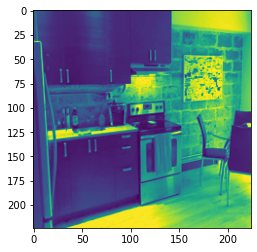

In [11]:
# # check some images
import matplotlib.pyplot as plt
plt.imshow(X_image[2,:,:,0]) #,cmap='gray')

In [127]:
#build model
model3 = Sequential()

model3.add(Conv2D(16, (3,3), padding = 'same',activation = 'relu', input_shape = X_image.shape[1:]))
model3.add(MaxPooling2D(pool_size=(2,2), padding= 'valid' ))
model3.add(Conv2D(16, (3,3), padding = 'same',activation = 'relu' ))
model3.add(MaxPooling2D(pool_size=(2,2), padding= 'valid' ))
model3.add(Flatten())

model3.add(Dense(16, activation = 'relu',
              kernel_regularizer=l2(0.01),
                 bias_regularizer=l2(0.01),
           activity_regularizer=l2(0.01)))
model3.add(Dense(prices_no, 
                 activation= 'softmax'))
model3.summary()

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_17 (Conv2D)          (None, 64, 64, 16)        448       
                                                                 
 max_pooling2d_12 (MaxPoolin  (None, 32, 32, 16)       0         
 g2D)                                                            
                                                                 
 conv2d_18 (Conv2D)          (None, 32, 32, 16)        2320      
                                                                 
 max_pooling2d_13 (MaxPoolin  (None, 16, 16, 16)       0         
 g2D)                                                            
                                                                 
 flatten_6 (Flatten)         (None, 4096)              0         
                                                                 
 dense_16 (Dense)            (None, 16)              

In [11]:
#compile model
# available optimizers: SGD, Adadelta, Adam, Adamax ,Adagrad, RMSprop, Nadam
optimizer = Adam(learning_rate=0.01)
batch = 16
epoch = 20
#add early stopping
es = EarlyStopping(monitor='val_accuracy', mode='max', verbose=1, patience=5)
model3.compile(loss='sparse_categorical_crossentropy', optimizer= optimizer, metrics=['accuracy'])

In [12]:
#Train model
model3.fit(X_image, y_price, validation_split=0.3, batch_size = batch, epochs = epoch
           , callbacks = [es])

Epoch 1/20
334/334 [==============================] - 17s 48ms/step - loss: 6.8418 - accuracy: 0.6040 - val_loss: 1.0566 - val_accuracy: 0.6317
Epoch 2/20
334/334 [==============================] - 15s 45ms/step - loss: 1.0530 - accuracy: 0.6165 - val_loss: 1.0211 - val_accuracy: 0.6317
Epoch 3/20
334/334 [==============================] - 19s 57ms/step - loss: 1.0271 - accuracy: 0.6165 - val_loss: 1.0022 - val_accuracy: 0.6308
Epoch 4/20
334/334 [==============================] - 18s 55ms/step - loss: 1.0085 - accuracy: 0.6167 - val_loss: 0.9822 - val_accuracy: 0.6308
Epoch 5/20
334/334 [==============================] - 18s 53ms/step - loss: 0.9898 - accuracy: 0.6161 - val_loss: 0.9662 - val_accuracy: 0.6308
Epoch 6/20
334/334 [==============================] - 15s 46ms/step - loss: 0.9744 - accuracy: 0.6163 - val_loss: 0.9558 - val_accuracy: 0.6317
Epoch 6: early stopping


In [13]:
#load test images
X_test_image = np.array([load_image(i) for i in tqdm(df_test.image)])

  0%|          | 0/7360 [00:00<?, ?it/s]

In [14]:
#predict and save to file
y_hat = model3.predict(X_test_image)
y_hat.shape

(7360, 3)

In [15]:
price_predicted = np.argmax(y_hat, axis=1)

dummy  = pd.DataFrame({'id': df_test.id, 'price': price_predicted})
dummy.to_csv('T3.2.csv', index=False)


<a class="anchor" id="t4"></a>

# Trail 4: Image Input with Dropout

##  
Image performed a little better that the text, with `val_accuracy`0.63 . it is a light change but it could mean that the text models were not extracting enough features.

Here i'll add more conv layers, maybe this is what the text model needed ( more feature extraction) also, we 'll explore the effect of dropout layer over the model .
Another slight change is the shape of the y_price, I will encode it wit oneHot, and change the loss to categorical instead of sparse_categorical, because i feel something iswrong there. maybe the previous code was wrong ?!

**plan**
- same design as Trial 3 
- add dropout layers
- add more conv layers 
- **corrective action** add class_weight 

In [128]:
#build model
model4 = Sequential()
# 1st Convolutional Layer
model4.add(Conv2D(filters=96, kernel_size=(7,7), strides=(3,3), 
                  padding='valid',activation = 'relu', 
                  input_shape =(64,64,3)))
model4.add(MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='same'))

# 2nd Convolutional Layer
model4.add(Conv2D(filters=384, kernel_size=(5,5), strides=(1,1), padding='valid'))
model4.add(Activation('relu'))
model4.add(MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='same'))
# Add Dropout to prevent overfitting
model4.add(Dropout(0.4))
# 3rd Convolutional Layer
model4.add(Conv2D(filters=256, kernel_size=(3,3), strides=(1,1), padding='valid'))
model4.add(Activation('relu'))

#flatten the output
model4.add(Flatten())

#add fully connected
model4.add(Dense(128, input_shape=(64*64*3,), 
                 kernel_regularizer=l2(0.02),
                 bias_regularizer=l2(0.02),
                activity_regularizer=l2(0.02) ) )
model4.add(Activation('relu'))
model4.add(Dense(prices_no,  activation= 'softmax'))

model4.summary()

Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_19 (Conv2D)          (None, 20, 20, 96)        14208     
                                                                 
 max_pooling2d_14 (MaxPoolin  (None, 10, 10, 96)       0         
 g2D)                                                            
                                                                 
 conv2d_20 (Conv2D)          (None, 6, 6, 384)         921984    
                                                                 
 activation_15 (Activation)  (None, 6, 6, 384)         0         
                                                                 
 max_pooling2d_15 (MaxPoolin  (None, 3, 3, 384)        0         
 g2D)                                                            
                                                                 
 conv2d_21 (Conv2D)          (None, 1, 1, 256)       

In [129]:
# turn the y_price into sparse (do oneHot encoding)
from keras.utils import np_utils
y_price = df.price
y_price_sparse = np_utils.to_categorical(y_price)

In [130]:
#compile model
# available optimizers: SGD, Adadelta, Adam, Adamax ,Adagrad, RMSprop, Nadam
optimizer = Adamax(learning_rate=0.1)
batch = 32
epoch = 20
#add early stopping
es = EarlyStopping(monitor='val_accuracy', mode='max', verbose=1, patience=5)
model4.compile(loss='categorical_crossentropy', optimizer= optimizer,
               metrics=['accuracy'])

In [131]:
#define class weights
class_weight={
                   0: 4,
                   1: 2,
                   2: 1
               }
model4.fit(X_image, y_price_sparse,
           validation_split=0.2, batch_size = batch, epochs = epoch
           , callbacks = [es] , class_weight=None )

Epoch 1/20
191/191 [==============================] - 70s 363ms/step - loss: 29222408028160.0000 - accuracy: 0.5617 - val_loss: 28.3746 - val_accuracy: 0.3119
Epoch 2/20
191/191 [==============================] - 72s 378ms/step - loss: 1389.4868 - accuracy: 0.4747 - val_loss: 26.1636 - val_accuracy: 0.3119
Epoch 3/20
191/191 [==============================] - 72s 378ms/step - loss: 451.0813 - accuracy: 0.6120 - val_loss: 19.3119 - val_accuracy: 0.6245
Epoch 4/20
191/191 [==============================] - 75s 393ms/step - loss: 163.1584 - accuracy: 0.5920 - val_loss: 17.0149 - val_accuracy: 0.6245
Epoch 5/20
191/191 [==============================] - 74s 386ms/step - loss: 65.8410 - accuracy: 0.6197 - val_loss: 15.2603 - val_accuracy: 0.6245
Epoch 6/20
191/191 [==============================] - 70s 369ms/step - loss: 51.5930 - accuracy: 0.6173 - val_loss: 14.0253 - val_accuracy: 0.6245
Epoch 7/20
191/191 [==============================] - 73s 380ms/step - loss: 52.4268 - accuracy: 0.619

**Something is wrong, my model's `val_accuracy` is oscillating between two values, two FIXED values.
Lets check the model prediction on the training set**

In [34]:
# predict the same trainig set to compare results for each class
y_report = model4.predict(X_image)

In [36]:
from sklearn.metrics import classification_report
classification_report(y_price.values, np.argmax(y_report, axis=1), zero_division=True)

'              precision    recall  f1-score   support\n\n           0       0.62      1.00      0.77      4737\n           1       1.00      0.00      0.00      2403\n           2       1.00      0.00      0.00       487\n\n    accuracy                           0.62      7627\n   macro avg       0.87      0.33      0.26      7627\nweighted avg       0.76      0.62      0.48      7627\n'

**WHAT?!** 
Class 1 and 2 have no output.

Lets douple check withthe distribution

In [132]:
np.unique(y_report)

array([0], dtype=int64)

>So the model is not learning at all, it is just predicting one value, one class


<a class="anchor" id="t4.1"></a>
# Trial 4.1: AlexNet Architecture
**observations:**

Nothing is making the model learn so far. It keeps predicting one class or the other. What does this mean?!

Is it the architecture? is my design week and can't extract features? 

- so lets make sure it is not the archetecture by running AlexNet archeticture.

**plan:**
I loaded the images with size (224, 224, 3) for the original AlexNet architecture, And ran it for 3 epochs. Any more epochs would crach my pc, and google colab was not giving me enough RAM for the image loading.

so here is the structure

In [12]:
model_alex = Sequential()
model_alex.add(Conv2D(filters=96, kernel_size=(11,11), strides=(4,4), padding='valid', input_shape = X_image.shape[1:]))
model_alex.add(Activation('relu'))
model_alex.add(MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='valid'))

# 2nd Convolutional Layer
model_alex.add(Conv2D(filters=256, kernel_size=(11,11), strides=(1,1), padding='valid'))
model_alex.add(Activation('relu'))
model_alex.add(MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='valid'))

# 3rd Convolutional Layer
model_alex.add(Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), padding='valid'))
model_alex.add(Activation('relu'))

# 4th Convolutional Layer
model_alex.add(Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), padding='valid'))
model_alex.add(Activation('relu'))

# 5th Convolutional Layer
model_alex.add(Conv2D(filters=256, kernel_size=(3,3), strides=(1,1), padding='valid'))
model_alex.add(Activation('relu'))
model_alex.add(MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='valid'))

# Passing it to a Fully Connected layer
model_alex.add(Flatten())

# 1st Fully Connected Layer
model_alex.add(Dense(4096, input_shape=(224*224*3,)))
model_alex.add(Activation('relu'))
# Add Dropout to prevent overfitting
model_alex.add(Dropout(0.4))

# 2nd Fully Connected Layer
model_alex.add(Dense(4096))
model_alex.add(Activation('relu'))
# Add Dropout
model_alex.add(Dropout(0.4))

# 3rd Fully Connected Layer
model_alex.add(Dense(3))
model_alex.add(Activation('softmax'))

model_alex.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 54, 54, 96)        34944     
                                                                 
 activation (Activation)     (None, 54, 54, 96)        0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 27, 27, 96)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 17, 17, 256)       2973952   
                                                                 
 activation_1 (Activation)   (None, 17, 17, 256)       0         
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 8, 8, 256)        0         
 2D)                                                    

In [13]:
#compile model
# available optimizers: SGD, Adadelta, Adam, Adamax ,Adagrad, RMSprop, Nadam
optimizer = Adamax(learning_rate=0.1)
batch = 32
epoch = 20
#add early stopping
es = EarlyStopping(monitor='val_accuracy', mode='max', verbose=1, patience=5)
model_alex.compile(loss='sparse_categorical_crossentropy', optimizer= optimizer,
               metrics=['accuracy'])

In [14]:
#Train model
# class_weight={
#                    0: 1,
#                    1: 1,
#                    2: 4
#                }
model_alex.fit(X_image, y_price, validation_split=0.2, batch_size = batch, epochs = epoch
           , callbacks = [es]) # , class_weight=class_weight )

Epoch 1/20
191/191 [==============================] - 160s 754ms/step - loss: 329635216752640.0000 - accuracy: 0.4086 - val_loss: 1401.9788 - val_accuracy: 0.6245
Epoch 2/20
191/191 [==============================] - 136s 711ms/step - loss: 117291.1797 - accuracy: 0.4471 - val_loss: 46.6714 - val_accuracy: 0.6252
Epoch 3/20
191/191 [==============================] - 135s 708ms/step - loss: 1226.8993 - accuracy: 0.5555 - val_loss: 0.9283 - val_accuracy: 0.6252
Epoch 4/20
 30/191 [===>..........................] - ETA: 1:47 - loss: 1.3519 - accuracy: 0.5615

KeyboardInterrupt: 

>This was the output of the AlexNet structure, So the architecture is not te be blamed for our problem.

**problem** model is predicting only one class ( the majority class), this could mean that the training is stuck at a local minima of the loss curve

**solution:**
Try Different Optimizer(something with momentum) and different learning rates, and maybe different initialization for the weights. if that doesn't work, change the loss function 

<a class="anchor" id="t5"></a>

# Trial 5: Multi-modality learning
 
*means learn with both text and image to solve one task*
**plan** build model to take in text and image input separatley then compine the result of their features togetherin one Fully connected layer to predict the price of the sample.

Also use functional method to build the model, since we need to build its layers parallel in the beginning.

- Try  different optimizers:
- different learning rates
- try to change the loss function

In [161]:
#build model
#input layers
in_text = keras.Input(batch_shape=(None, max_len))
in_image = keras.Input(batch_shape=(None, 64, 64, 3)) #the image shape


#embedding layer for text input
embedded = keras.layers.Embedding(vocab_size, 100)(in_text)
#1st LSTM
lstm1 = LSTM(16, 
                activation = 'tanh', 
                kernel_regularizer=l1(0.01),
                recurrent_regularizer=l1(0.01),
                bias_regularizer=l1(0.01),return_sequences= True
               )(embedded) 
drop_lstm1 = Dropout(0.5)(lstm1)

#2nd LSTM
lstm2 = LSTM(8, 
                activation = 'tanh', 
                kernel_regularizer=l1(0.01),
                recurrent_regularizer=l1(0.01),
                bias_regularizer=l1(0.01)
               )(drop_lstm1)

# image part 
# 1st conv
cov1 = Conv2D(32, (5, 5), padding = 'valid',activation = 'relu')(in_image)
pl1 = MaxPool2D((5, 5), padding='valid')(cov1)
drop_conv1 = Dropout(0.5)(pl1)

# 2nd conv
#more filters to open up the space
cov2 = Conv2D(64, (3, 3), padding = 'same',activation = 'relu')(drop_conv1)
pl2 = MaxPool2D((3, 3), padding='valid')(cov2)
drop_conv2 = Dropout(0.5)(pl2)

# 3rd conv
cov3 = Conv2D(16, (3, 3), padding = 'same',activation = 'relu')(drop_conv2)
pl3 = MaxPool2D((3, 3), padding='valid')(cov3)
drop_conv3 = Dropout(0.5)(pl3)

flattened = Flatten()(drop_conv3)


# fusion - combinig both
fused = tf.concat([lstm2, flattened], axis=-1)

#fully cnnected layer for the final prediction
p_price = Dense(prices_no, activation='softmax', name='price')(fused)

# define model input/output with dictionary.
model5 = keras.Model(
    inputs={
        'summary': in_text,
        'image': in_image
    },
    outputs=
        p_price
)

model5.summary()

Model: "model_7"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_22 (InputLayer)          [(None, 64, 64, 3)]  0           []                               
                                                                                                  
 conv2d_52 (Conv2D)             (None, 60, 60, 32)   2432        ['input_22[0][0]']               
                                                                                                  
 max_pooling2d_46 (MaxPooling2D  (None, 12, 12, 32)  0           ['conv2d_52[0][0]']              
 )                                                                                                
                                                                                                  
 dropout_49 (Dropout)           (None, 12, 12, 32)   0           ['max_pooling2d_46[0][0]'] 

In [164]:
#compile the model 
model5.compile(
    optimizer=Adam(learning_rate=0.01),
    loss= 'sparse_categorical_crossentropy',
    metrics='SparseCategoricalAccuracy'

)

In [166]:
batch = 32
epoch = 20
#add early stopping to counterfit overfitting
es = EarlyStopping(monitor='val_sparse_categorical_accuracy', mode='max', verbose=1, patience=5)

class_weights = {
    0: 2,
    1: 8,
    2: 16
}
#train the model
# add the inputs separately in dict
model5.fit(x={
    'summary': X_text_id, 
    'image': X_image
}, 
           y= y_price , 
          batch_size=batch,
          epochs=epoch,
          validation_split=0.2,
           class_weight=class_weights,
          callbacks=[es])

Epoch 1/20
191/191 [==============================] - 53s 244ms/step - loss: 18.2543 - sparse_categorical_accuracy: 0.3172 - val_loss: 1.2607 - val_sparse_categorical_accuracy: 0.3119
Epoch 2/20
191/191 [==============================] - 45s 237ms/step - loss: 5.0058 - sparse_categorical_accuracy: 0.3158 - val_loss: 1.2346 - val_sparse_categorical_accuracy: 0.3119
Epoch 3/20
191/191 [==============================] - 47s 244ms/step - loss: 4.9935 - sparse_categorical_accuracy: 0.3158 - val_loss: 1.2406 - val_sparse_categorical_accuracy: 0.3119
Epoch 4/20
191/191 [==============================] - 47s 245ms/step - loss: 4.9859 - sparse_categorical_accuracy: 0.3158 - val_loss: 1.2092 - val_sparse_categorical_accuracy: 0.3119
Epoch 5/20
191/191 [==============================] - 46s 242ms/step - loss: 4.9789 - sparse_categorical_accuracy: 0.3158 - val_loss: 1.2402 - val_sparse_categorical_accuracy: 0.3119
Epoch 6/20
191/191 [==============================] - 47s 247ms/step - loss: 4.9815 

In [169]:
#predict and save to file
# get the test images
X_test_image = np.array([load_image(initial_path + i) for i in tqdm(df_test.image)])
y_hat = model5.predict(x = 
                       {'summary':X_test_text_id,
                        'image': X_test_image}
                            )
y_hat

  0%|          | 0/7360 [00:00<?, ?it/s]

array([[0.25123304, 0.53218085, 0.21658608],
       [0.25123304, 0.53218085, 0.21658608],
       [0.25123304, 0.53218085, 0.21658608],
       ...,
       [0.25123304, 0.53218085, 0.21658608],
       [0.25123304, 0.53218085, 0.21658608],
       [0.25123304, 0.53218085, 0.21658608]], dtype=float32)

In [172]:
#get the highes class predicted
price_predicted = np.argmax(y_hat, axis=1)

#save to file
dummy  = pd.DataFrame({'id': df_test.id, 'price': price_predicted})
dummy.to_csv('T5.csv', index=False)


<a class="anchor" id="t6"></a>

# Trial 6: Multi-objective learning.(predicting both price and type

Still no learning. I lost hope two Trails ago. 
VAl_accuracy is fixed at a point 0.62. 

Lets just do the last trial anyway.
same as Trial 5 but making the model predict both the price and the type of the rental based on both the summary(text) and images

In [167]:
#build first layers for the input separately
in_text = keras.Input(batch_shape=(None, max_len))
in_image = keras.Input(batch_shape=(None, 64, 64, 3)) #the image shape

# text part
#
embedded = keras.layers.Embedding(vocab_size, 100)(in_text)

lstm1 = LSTM(16, 
                activation = 'tanh', 
                kernel_regularizer=l1(0.01),
                recurrent_regularizer=l1(0.01),
                bias_regularizer=l1(0.01),return_sequences= True
               )(embedded) 
drop_lstm1 = Dropout(0.5)(lstm1)
lstm2 = LSTM(8, 
                activation = 'tanh', 
                kernel_regularizer=l1(0.01),
                recurrent_regularizer=l1(0.01),
                bias_regularizer=l1(0.01)
               )(drop_lstm1)

# image part 
cov1 = Conv2D(32, (5, 5), padding = 'valid',activation = 'relu')(in_image)
pl1 = MaxPool2D((5, 5), padding='valid')(cov1)
drop_conv1 = Dropout(0.5)(pl1)

#more filters to open up the space
cov2 = Conv2D(64, (3, 3), padding = 'same',activation = 'relu')(drop_conv1)
pl2 = MaxPool2D((3, 3), padding='valid')(cov2)
drop_conv2 = Dropout(0.5)(pl2)

cov3 = Conv2D(16, (3, 3), padding = 'same',activation = 'relu')(drop_conv2)
pl3 = MaxPool2D((3, 3), padding='valid')(cov3)
drop_conv3 = Dropout(0.5)(pl3)

flattened = Flatten()(drop_conv3)

# fusion - combinig both
fused = tf.concat([lstm2, flattened], axis=-1)

# multi-task learning (each is a multi-class classification)
# one dense layer for each task
p_type = Dense(types_no, activation='softmax', name='type')(fused)
p_price = Dense(prices_no, activation='softmax', name='price')(fused)


# define model input two modes
# model output two objects
model6 = keras.Model(
    inputs={
        'summary': in_text,
        'image': in_image
    },
    outputs={
        'type': p_type,
        'price': p_price,
    },
)
#view the model details
model6.summary()

Model: "model_8"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_24 (InputLayer)          [(None, 64, 64, 3)]  0           []                               
                                                                                                  
 conv2d_55 (Conv2D)             (None, 60, 60, 32)   2432        ['input_24[0][0]']               
                                                                                                  
 max_pooling2d_49 (MaxPooling2D  (None, 12, 12, 32)  0           ['conv2d_55[0][0]']              
 )                                                                                                
                                                                                                  
 dropout_53 (Dropout)           (None, 12, 12, 32)   0           ['max_pooling2d_49[0][0]'] 

In [174]:
#copile the model
model6.compile(
    optimizer=Adam(),
    loss={
        'type': 'sparse_categorical_crossentropy',
        'price': 'sparse_categorical_crossentropy',
    },
    # add learning weights to prioritize the price output
    loss_weights={
        'type': 0.2,
        'price': 1,       
    },
    metrics={
        'type': ['SparseCategoricalAccuracy'],
        'price': ['SparseCategoricalAccuracy'],
    },
)

In [175]:
batch = 32
epoch = 20
#add early stopping to counterfit overfitting
es = EarlyStopping(monitor='val_price_sparse_categorical_accuracy', mode='max', verbose=1, patience=5)
#train the model

model6.fit(x={
    'summary': X_text_id, 
    'image': X_image
}, 
           y={'type': y_type,
           'price': y_price} ,
          batch_size=batch,
          epochs=epoch,
          validation_split=0.2,
          callbacks=[es])

Epoch 1/20
191/191 [==============================] - 83s 363ms/step - loss: 11.3160 - price_loss: 5.8067 - type_loss: 10.1292 - price_sparse_categorical_accuracy: 0.5152 - type_sparse_categorical_accuracy: 0.4365 - val_loss: 1.9071 - val_price_loss: 0.8408 - val_type_loss: 1.8868 - val_price_sparse_categorical_accuracy: 0.6252 - val_type_sparse_categorical_accuracy: 0.7647
Epoch 2/20
191/191 [==============================] - 65s 340ms/step - loss: 1.5923 - price_loss: 0.8754 - type_loss: 1.4556 - price_sparse_categorical_accuracy: 0.6050 - type_sparse_categorical_accuracy: 0.7330 - val_loss: 1.3743 - val_price_loss: 0.8311 - val_type_loss: 1.2477 - val_price_sparse_categorical_accuracy: 0.6252 - val_type_sparse_categorical_accuracy: 0.7647
Epoch 3/20
191/191 [==============================] - 73s 383ms/step - loss: 1.3547 - price_loss: 0.8552 - type_loss: 1.1984 - price_sparse_categorical_accuracy: 0.6109 - type_sparse_categorical_accuracy: 0.7504 - val_loss: 1.2844 - val_price_loss:

In [ ]:
#predict and save to file
y_hat = model6.predict(x = 
                       {'summary':X_test_text_id,
                        'image': X_test_image}
                            )
y_hat

{'price': array([[0.6179501 , 0.31807163, 0.06397825],
        [0.6179501 , 0.31807163, 0.06397825],
        [0.6179501 , 0.31807163, 0.06397825],
        ...,
        [0.6179501 , 0.31807163, 0.06397825],
        [0.6179501 , 0.31807163, 0.06397825],
        [0.6179501 , 0.31807163, 0.06397825]], dtype=float32)}

In [ ]:
price_predicted = np.argmax(y_hat['price'], axis=1)

dummy  = pd.DataFrame({'id': df_test.id, 'price': price_predicted})
dummy.to_csv('T6.csv', index=False)

<a class="anchor" id="conc"></a>
# Conclusion:
As usual, I still have more experiments i want to try, but again, as usual i'll try them in my own time since this assignment's due in a couple of hours :D .

But one thing for sure, all of my models were not learning. The `val_accuracy` was the same 0.625  through most of the trials. Sometimes it was 0.311, but that is just another class dominating the loss curve.

My thoughts in order of most probalbe; 

- The model is stuck at local minima, at which the majority class gives a local maxima accuracy and a local minima loss.  so it is not getting any better.
- The imbalance in the classes is causing this.
- one fatal mistake repeated in all trials(a universal bug :D) 
- ~~bad archetecture~~: no since we tried the AlexNet

## Corrective Actions: *Future Plans*

- For the first hypothesis **Local Minima** i think a different initialization of the weights could do the trick. Other solutions may include changing the loss function, maybe hard-code one of my own instead of the built-in `spase_categoricalcrossentropy`. I already tried Different optimizers and Different Learning rates.
- 2nd Hypothesis: try Data Augmentation for the minority classes, like class2(6% of the total train set) and class1 (30%), maybe just flip their images and create more samples with the flipped images. Also, notice that Data Augmentation is very important for vision problems( the model won't identify something it didn't see before
- Take the laze road: Sleep on it, maybe it will solve itself in the morning :D 